In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import json

model_dict = json.load(open("checkpoint-8.json"))

def parse_success_dict(model_dict: dict):
    """
    model_dict: mapping solver name -> binary string like "100101..." indicating
    which problems that solver solves.
    Returns solver names list and success_matrix of shape (n_solvers, n_problems).
    """
    solvers = list(model_dict.keys())
    # assume all strings are same length and consist of '0'/'1'
    success_matrix = np.array(
        [[int(c) for c in model_dict[name]] for name in solvers],
        dtype=int
    )  # shape: (n_solvers, n_problems)
    return solvers, success_matrix

solvers, success_matrix = parse_success_dict(model_dict['model_dict'])
print(solvers)
print(success_matrix)
#

['AI-MO_Kimina-Prover-Preview-Distill-7B', 'ByteDance-Seed_BFS-Prover', 'Goedel-LM_Goedel-Prover-SFT', 'deepseek-ai_DeepSeek-Prover-V1', 'deepseek-ai_DeepSeek-Prover-V1.5-RL', 'deepseek-ai_DeepSeek-Prover-V2-7B', 'kfdong_STP_model_Lean', 'stoney0062_Leanabell-Prover-DS-SFT', 'wellecks_llmstep-mathlib4-pythia2.8b']
[[1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1
  0 0 0 0]
 [1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1
  0 0 0 0]
 [1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0
  0 0 0 0]
 [1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1
  0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0]
 [1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1
  0 0 0 0]
 [1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1
  0 0 0 0]
 [0 

In [2]:
from itertools import combinations

def compute_ensemble_metrics(success_matrix: np.ndarray, r: int):
    """
    For each ensemble (subset of r solvers), compute:
      - SSR: fraction of problems solved by exactly one solver in the ensemble.
      - S0: coverage = fraction of problems solved by at least one solver.
    Returns a DataFrame with columns: 'ensemble' (tuple of solver indices), 'SSR', 'S0'.
    """
    n_solvers, n_problems = success_matrix.shape
    ensembles = list(combinations(range(n_solvers), r))

    records = []
    for ens in ensembles:
        sub = success_matrix[np.array(ens), :]  # shape (r, n_problems)
        counts = sub.sum(axis=0)
        ssr = np.mean(counts == 1)
        s0 = np.mean(counts > 0)
        records.append({
            "ensemble": ens,
            "SSR": ssr,
            "S0": s0,
        })
    return pd.DataFrame.from_records(records)

df = compute_ensemble_metrics(success_matrix, 3)

In [3]:
df["SSR"]

,SSR
0,0.200
1,0.100
2,0.175
3,0.150
4,0.150
...,...
79,0.375
80,0.275
81,0.150
82,0.350


In [4]:
df["S0"]

,S0
0,0.600
1,0.500
2,0.475
3,0.500
4,0.500
...,...
79,0.525
80,0.550
81,0.300
82,0.525


# Fitting using only s0 (

In [35]:
import statsmodels.api as sm

def fit_ssr_on_s0(ssr, s0, robust=True, add_intercept=True):
    """
    Fit SSR ~ S0.
    ssr, s0: 1d arrays of same length.
    """
    X = s0[:, None]
    if add_intercept:
        X = sm.add_constant(X)
    cov_type = "HC3" if robust else "nonrobust"
    model = sm.OLS(ssr, X).fit(cov_type=cov_type)
    return model

model = fit_ssr_on_s0(df["SSR"].to_numpy(), df["S0"].to_numpy())
print(model.summary())  # coefficient on S0, its p-value, R^2, etc.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.08687
Date:                Sat, 02 Aug 2025   Prob (F-statistic):              0.769
Time:                        04:31:31   Log-Likelihood:                 88.874
No. Observations:                  84   AIC:                            -173.7
Df Residuals:                      82   BIC:                            -168.9
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1744      0.039      4.468      0.0

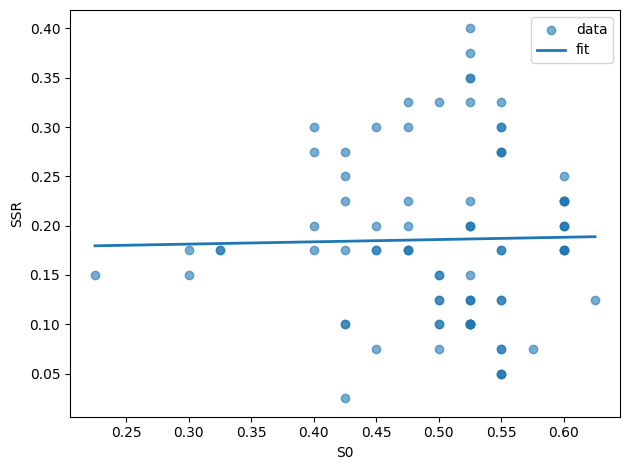

In [6]:
import matplotlib.pyplot as plt

s0 = df["S0"].to_numpy()
ssr = df["SSR"].to_numpy()
pred = model.predict(sm.add_constant(s0))

plt.scatter(s0, ssr, alpha=0.6, label="data")
plt.plot(np.sort(s0), pred[np.argsort(s0)], label="fit", linewidth=2)
plt.xlabel("S0")
plt.ylabel("SSR")
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
def fit_ssr_model(ssr, edc, s0, robust=True):
    X = np.column_stack([edc, s0])
    Xc = sm.add_constant(X)
    cov_type = "HC3" if robust else "nonrobust"
    model = sm.OLS(ssr, Xc).fit(cov_type=cov_type)
    return model

edc_i = [0.3344948784002142,0.3344950667613536,0.3344950643502867,0.3344950716700126,0.33449505666093415,0.33449487018758833,0.334494086962233,0.49692708977867994,0.49715749538435067,0.49576636545103153,0.49604683373032427,0.334152885640466,0.4999991959604131,0.3338499482869377,0.49538887236164797,0.4950040790755435,0.49490338995815125,0.4999993230153705,0.4953275460602639,0.49469948565212424,0.4947236464570661,0.4999993315552104,0.494423631459739,0.49244407277776386,0.49999934273278823,0.49476603809200864,0.4999993296742038,0.49999922018822535,0.49692708635529215,0.49715749286796357,0.4957663612832934,0.4960468294140969,0.3341528946814852,0.4999992949564221,0.33384995088157216,0.49538887330493137,0.4950040798703377,0.494903404110192,0.49999942712240103,0.49532754791054795,0.49469948735391905,0.4947236615161075,0.4999994365692417,0.4944236315101828,0.4924440861854542,0.4999994460954684,0.49476605135120977,0.49999943288839477,0.4999993367596629,0.32793500072633225,0.4880827858966465,0.48797847575042397,0.3259840383737658,0.4969271549312773,0.4882518685190007,0.48790429125074297,0.326034703796419,0.4971575723948556,0.4862372981539617,0.3223639912127207,0.4957664446680374,0.3249664396668474,0.4960469147493349,0.33415305700409054,0.3245666450820863,0.3235538062484314,0.32347747776657343,0.3338499691022821,0.48481686715967953,0.4827368191909045,0.4953888953834933,0.484674006079634,0.4950041038993936,0.4949035051266153,0.48445095075294375,0.48249575270650286,0.4953275809400168,0.48418967247319716,0.49469952233388187,0.4947237734834377,0.4816342356304328,0.49442367034799756,0.4924442020106364,0.4947661691268858]
cohesion_i = [1 - edc for edc in edc_i]
count = 84
model_1 = fit_ssr_model(df["SSR"][:count], edc_i[:count], df["S0"][:count])
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    SSR   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     8.496
Date:                Sat, 02 Aug 2025   Prob (F-statistic):           0.000447
Time:                        05:24:39   Log-Likelihood:                 95.596
No. Observations:                  84   AIC:                            -185.2
Df Residuals:                      81   BIC:                            -177.9
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0578      0.071     -0.810      0.4

In [57]:
from sklearn.linear_model import RidgeCV, LassoCV

def fit_regularized(ssr: np.ndarray, edc: np.ndarray, s0: np.ndarray):
    """
    Fit regularized alternatives (ridge and lasso) to SSR ~ EDC + S0 for comparison.
    """
    X = np.column_stack([edc, s0])
    # no intercept here; these estimators include their own internal handling if needed
    ridge = RidgeCV(alphas=np.logspace(-4, 4, 50), store_cv_values=True).fit(X, ssr)
    lasso = LassoCV(cv=5, max_iter=5000).fit(X, ssr)
    return ridge, lasso


ridge, lasso = fit_regularized(df["SSR"][:count], edc_i, df["S0"][:count])
print("Ridge alpha:", ridge.alpha_)
print("Ridge coefs:", ridge.coef_)

print("Lasso alpha:", lasso.alpha_)
print("Lasso coefs:", lasso.coef_)

Ridge alpha: 0.040949150623804234
Ridge coefs: [0.41666564 0.06237246]
Lasso alpha: 0.0003687556859533227
Lasso coefs: [0.37609684 0.00155173]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
